## Generating facies realizations with GeostatsPy

We generate here a set of facies realizations (sand/ shale) using the fantastic geostatistical library _geostatspy_ (https://github.com/GeostatsGuy/GeostatsPy) by Michael Pyrcz (University of Texas, Austin).

The example is modified from his notebook https://github.com/GeostatsGuy/PythonNumericalDemos/GeostatsPy_sisim.ipynb

In [134]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats



### Load Data

We are using a data set that is also provided by Michael Pyrcz on https://github.com/GeostatsGuy/GeoDataSets

In [135]:
df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
df.describe()                                             # summary statistics 
df = df.sample(100)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df.head(n=10)

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,347,549,900.0,109.0,1.0,0.172168,52.273043,4354.446742
1,335,529,950.0,99.0,1.0,0.174671,88.241632,5689.415440
2,278,443,720.0,899.0,1.0,0.148054,18.235939,4657.906573
3,114,187,200.0,389.0,1.0,0.121670,3.254674,4836.252830
4,256,412,500.0,579.0,0.0,0.098164,6.596546,5681.646332
5,237,388,710.0,529.0,0.0,0.112294,13.016758,6060.861075
6,338,532,200.0,999.0,0.0,0.120734,8.925150,5114.881659
7,104,172,830.0,819.0,1.0,0.124873,1.782012,4494.808666
8,343,540,100.0,359.0,1.0,0.107368,1.842103,5577.387475
9,51,76,900.0,500.0,0.0,0.086313,1.031717,5628.516203


### Generating Realizations

As a first step, we define the global model domain, the number of facies (with proportions) and the facies variograms:

In [136]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 64; ny = 64; xsiz = 1000./nx; ysiz = 1000./ny; xmn = 10.0; ymn = 10.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999
dummy_trend = np.zeros((11,11))            # the current version requires trend input - if wrong size it is ignored 

ncut = 2                                   # number of facies

if ncut == 2: # standard version
    thresh = [0,1]                             # the facies categories (use consistent order)
    gcdf = [0.4,0.6]                           # the global proportions of the categories
    varios = []                                # the variogram list
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # shale indicator variogram
    # varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram

if ncut == 3: # adjusted for three facies (FW)
    thresh = [0,0.3,1]                             # the facies categories (use consistent order)
    # gcdf = [0.4,0.6]                           # the global proportions of the categories
    gcdf = [0.1,0.1,0.8]                           # the global proportions of the categories
    varios = []                                # the variogram list
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # shale indicator variogram
    # varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # facies 2 indicator variogram

    

Before we generate realizations, we set the random seed for later reproducibility (Technical side note: seeds need to be generated for subsequent implementation of GSLib functions):

In [137]:
n_realizations = 500
np.random.seed(seed = 12345)
seeds = np.random.choice(10000, n_realizations, replace=False)
seeds

array([7867, 1402, 8606, 8885, 6494, 9628, 7459, 3964, 7000, 4470, 9996,
       1797, 4696,  716, 2188, 8613, 7553,  757, 1553, 3429, 8328, 7211,
       6835, 1137, 2827, 1757, 7872, 9124, 4851, 7308,  556, 6061, 3762,
       4371, 7001, 3474, 5623, 3819,  987, 9770, 5359, 9297, 7864, 6332,
       4318, 9026,  585, 3209, 9044, 9961, 8614, 2012,  951, 9037, 6221,
       4958, 9521, 3245, 4314, 3219, 1557, 7100, 8639, 4946, 5956, 5198,
       8092, 8085, 7300, 8580,  343, 5352, 4906,  239, 8866, 8381, 5368,
       7631, 6810,  313,  576, 2552, 7068, 4444,   15, 5027, 6492, 2147,
       6192, 2143, 3176, 1523, 8117, 5076,  680, 7922, 9987, 3444, 4960,
       2489, 7313, 5929, 3332, 9283, 5463, 1975,   29,  474, 8975, 4350,
        342, 9380, 3501, 7376, 5504,   28, 1817, 3258, 7727, 8448, 6699,
       4869,   34, 9360, 7006, 2061, 2395,  784, 8742, 6979, 1612, 9205,
       4674, 1895, 9242, 2241, 6603,  703, 5479, 1005, 7019, 8077, 9135,
       5885, 4394, 7667, 2786, 9473, 1594, 8564, 23

We now can generate realizations (approx. 10s per realization for settings above!):

In [ ]:
realizations = np.empty(shape=(n_realizations, nx, ny))

for i in range(n_realizations):
    
    # Added just for better checks during offline run:
    print("\n")
    print(80*"*")
    print("\n\n\t Realization %d \n\n"% i)
    print(80*"*")
    print("\n")
    
    realizations[i,:,:] = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=ncut,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
                   tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
                   nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seeds[i],
                   ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios)




********************************************************************************


	 Realization 0 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7867
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 1 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1402
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 2 


********************************************************************************


Data for IK3D: Variable column Facies

   currently on node 2048


********************************************************************************


	 Realization 22 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6835
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 23 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1137
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 24 


********************************************************************************


Data for



********************************************************************************


	 Realization 43 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6332
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 44 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4318
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 45 


********************************************************************************


Data for IK3D: Variable column Fac

   currently on node 2048


********************************************************************************


	 Realization 65 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 5198
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 66 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8092
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 67 


********************************************************************************


Data for

   currently on node 2048


********************************************************************************


	 Realization 87 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 2147
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 88 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6192
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 89 


********************************************************************************


Data for



********************************************************************************


	 Realization 108 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8975
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 109 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4350
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 110 


********************************************************************************


Data for IK3D: Variable column 

   currently on node 2048


********************************************************************************


	 Realization 130 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1612
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 131 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9205
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 132 


********************************************************************************


Data 



********************************************************************************


	 Realization 151 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4688
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 152 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6821
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 153 


********************************************************************************


Data for IK3D: Variable column 

   currently on node 2048


********************************************************************************


	 Realization 173 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7279
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 174 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 3797
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 175 


********************************************************************************


Data 

In [ ]:
plt.imshow(realizations[1])
plt.colorbar()

### Plot realizations

Just to get an impression, here a plot of some realizations:

In [ ]:
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(realizations[i])

...and here simply the sum:

In [ ]:
plt.imshow(np.sum(realizations, axis=0))
plt.colorbar()

...and the (estimated) probability for facies=1:

### Save realizations

Save realizations for further use later

In [ ]:
import pickle

In [ ]:
# add random int to filename to avoid overwriting


f = open("facies_realizations_ncut_f2_64x64.pkl", mode='wb')
pickle.dump(realizations, f)
f.close()

### Show conditioning points

It is also possible to show the conditioning points using proper GSLib functions - see github page of GeostatsPy (commented out here for now).

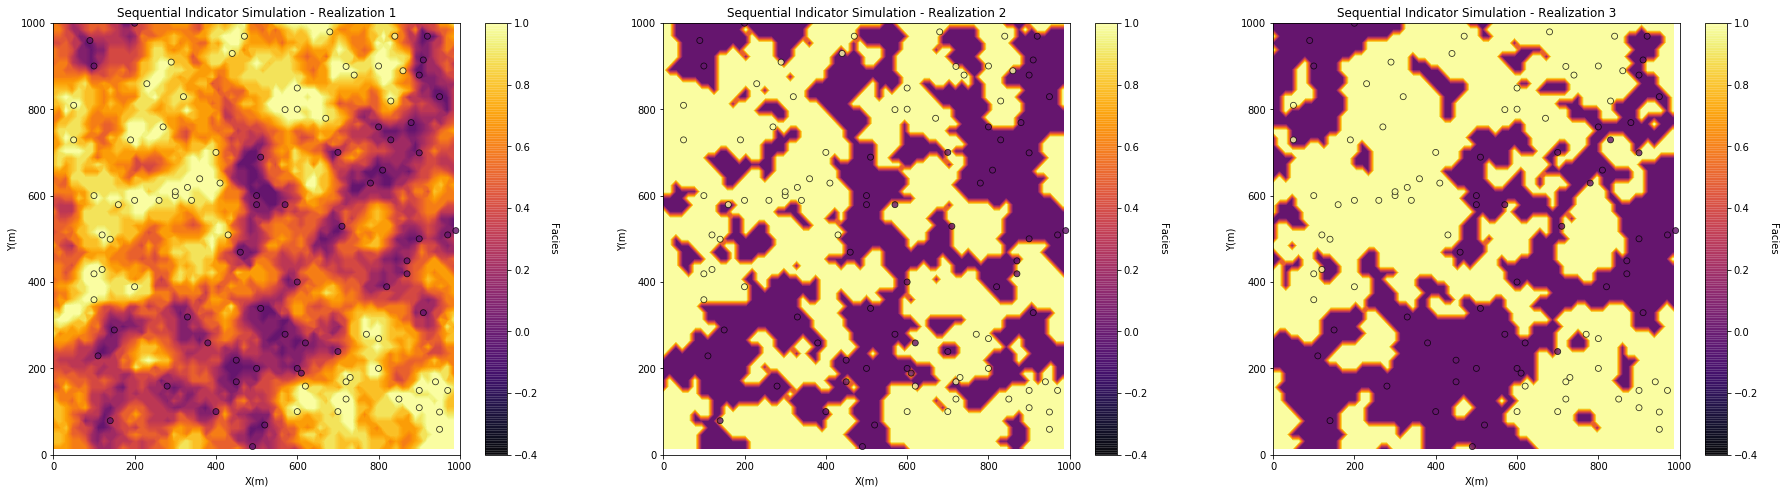

In [117]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(np.sum(realizations, axis=0)/n_realizations,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(realizations[1],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 2','X(m)','Y(m)','Facies',cmap)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(realizations[2],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 3','X(m)','Y(m)','Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

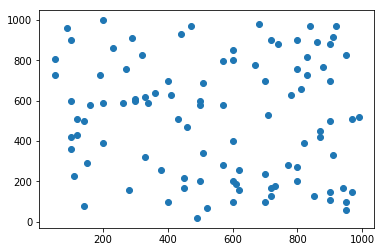

In [128]:
plt.plot(df['X'], df['Y'], 'o') #, c=df['Facies'])

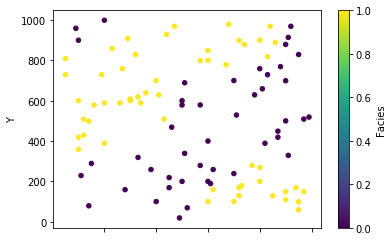

In [127]:
df.plot.scatter(x="X", y="Y", c="Facies", colormap='viridis')

In [118]:


f = open("data_frame.pkl", mode='wb')
pickle.dump(df, f)
f.close()

In [126]:
len(df)

100

### Adjust test data set

Include points for a third facies (based on first facies)


In [133]:
df[df["Facies"] == 1.0]

TypeError: '(0      True
1      True
2      True
3      True
4     False
5     False
6     False
7      True
8      True
9     False
10     True
11     True
12    False
13    False
14    False
15    False
16     True
17     True
18    False
19    False
20     True
21     True
22    False
23    False
24     True
25     True
26    False
27     True
28    False
29    False
      ...  
70     True
71     True
72     True
73    False
74    False
75     True
76     True
77     True
78    False
79    False
80     True
81     True
82    False
83    False
84    False
85     True
86     True
87    False
88    False
89     True
90    False
91    False
92     True
93     True
94    False
95     True
96    False
97     True
98    False
99    False
Name: Facies, Length: 100, dtype: bool, 'index')' is an invalid key